In [34]:
from google.cloud import bigquery
client_bq = bigquery.Client.from_service_account_json("./credentials.json", project='charged-dialect-824')

# Loading data from BQ

In [35]:
def load_bq_data(_sql):
    _df = client_bq.query(_sql).to_dataframe()
    return _df

In [36]:
sql = """
SELECT *
FROM RicardoInterview.product_detection_training_data
"""

df_load = load_bq_data(sql)
len(df_load)
df_load.head()

,articleId,title,subtitle,productType
0,-3393892867263864215,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation,cd
1,-2831118468819601923,Ekseption-The Lost Last Concert Tapes...,The Lost Last Concert Tapes (Box-Set),cd
2,6835807414137785977,PORTISHEAD CD-Sammlung 3 CDs #16,Kollektion für Fans der Trip-Hop-Pioniere aus ...,cd
3,-4912458353746230865,Primeon CD-R Rohlinge (bunt),39 Stück auf der Spindel,cd
4,1496864991301777371,Adonia - Zmittst im Füür,Markus Hottiger / Markus Heusser,cd


In [37]:
df = df_load
print(len(df))

37567


# Samples

In [38]:
df[['title','subtitle','productType']].fillna('').sample(20)

,title,subtitle,productType
36192,Adidas Badehose infinitex Gr.140,,swimming_trunks
2532,2 Heizoeltanks mit Auffangwannen.,30 jährige Oeltanks,tank
3911,Razer Mamba Gaming Mouse (rainbow),Tournament Edition,mouse
29331,♕Shabby Chic♕ Schablone A4 NEU,,template
3888,Puch Velux X30 Motor,Puch Velux Motor,moped
16416,Kaschmir 100% neuwertige Strickmütze,,cap
754,"Status Game 8,5x20 Felgen alle 5 Loch LK",Jantes für Audi Bmw VW Mercedes Skoda Renault ...,rim
14393,Table basse brillante Blanc,Hochglanz Couchtisch Weiß,bedside_table
17048,"Alufelge Black Rhino Pinnacle 17""",,rim
5471,"Weinkaraffe, 200ml, in guter Erhaltung","Masse: 16.5cm hoch, Fuss: 6cm, Bauch: 7.5cm im...",carafe


# Check languages and store to file

In [ ]:
from langdetect import detect
tqdm.pandas()

def get_lang(s):
    try:
        language = detect(s)
    except:
        language = "error"
        print(f"ERROR: {s}")
    return language

df['lang'] = (df['title'].fillna('').astype(str) + '. ' +  df['subtitle'].fillna('').astype(str)).progress_apply(lambda x: get_lang(x))

# store to file as backup
df.to_csv('../data/articles.csv',index=False)

# Load data from file

In [1]:
import pandas as pd 
import numpy as np
import plotly.express as px

df = pd.read_csv('../data/articles.csv')
print(len(df))

37567


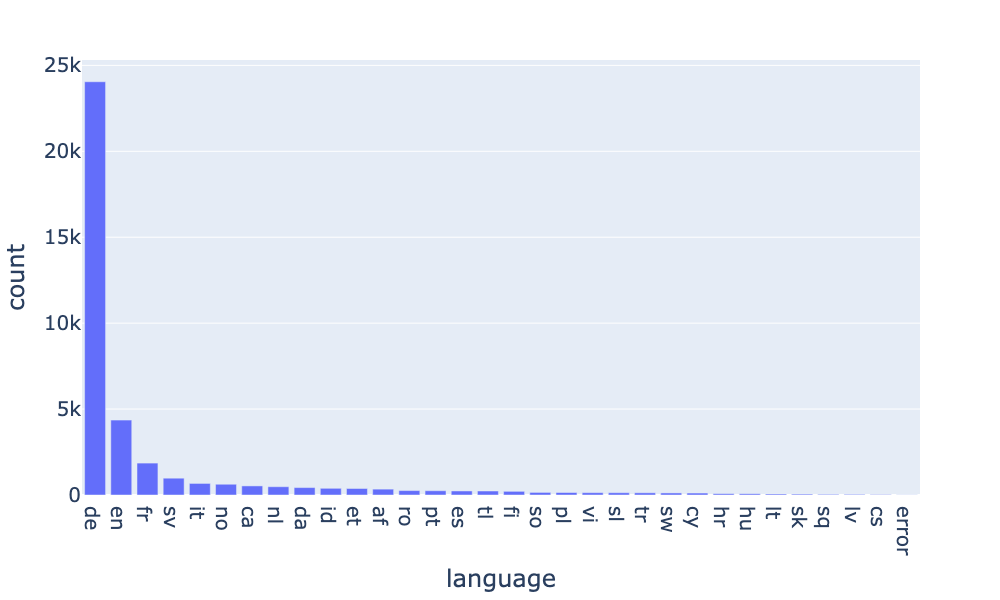

In [2]:
# Plot language distribution
fig = px.bar(df['lang'].value_counts(),height=600,width=1000)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    font=dict(
        size=20,
    ),
    showlegend=False,
    xaxis_title="language",
    yaxis_title="count"
)
fig.show("png")

In [ ]:
# Export for huggingface AutoNLP to obtain a baseline
df_de = df[ df['lang'] == 'de' ]
df_de[['text','productType']].to_csv('../data/articles_de_hf.csv',index=False)

# Read precomputed embeddings

In [5]:
# To compute embeddings, the methods in app/embeddings.py are used

# bert embeddings
vecs_bert = np.load('../data/embeddings_bert.npy')
print(vecs_bert.shape)

# Sparse embeddings
import scipy.sparse as sp
vecs_sp = sp.load_npz('../data/embeddings_sparse.npz')
print(vecs_sp.shape)

# Combine both embeddings
vecs = sp.hstack([sp.csr_matrix(vecs_bert),vecs_sp])
print(vecs.shape)


(37567, 768)
(37567, 8884)
(37567, 9652)


## Plot dense embedding

In [6]:
# Project to 2 dims with TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
vecs_ = tsne.fit_transform(vecs_bert)

In [7]:
df_plot = pd.DataFrame(vecs_)
df_plot['title'] = df['title']
df_plot['subtitle'] = df['subtitle']
df_plot['productType'] = df['productType']
df_plot['lang'] = df['lang']

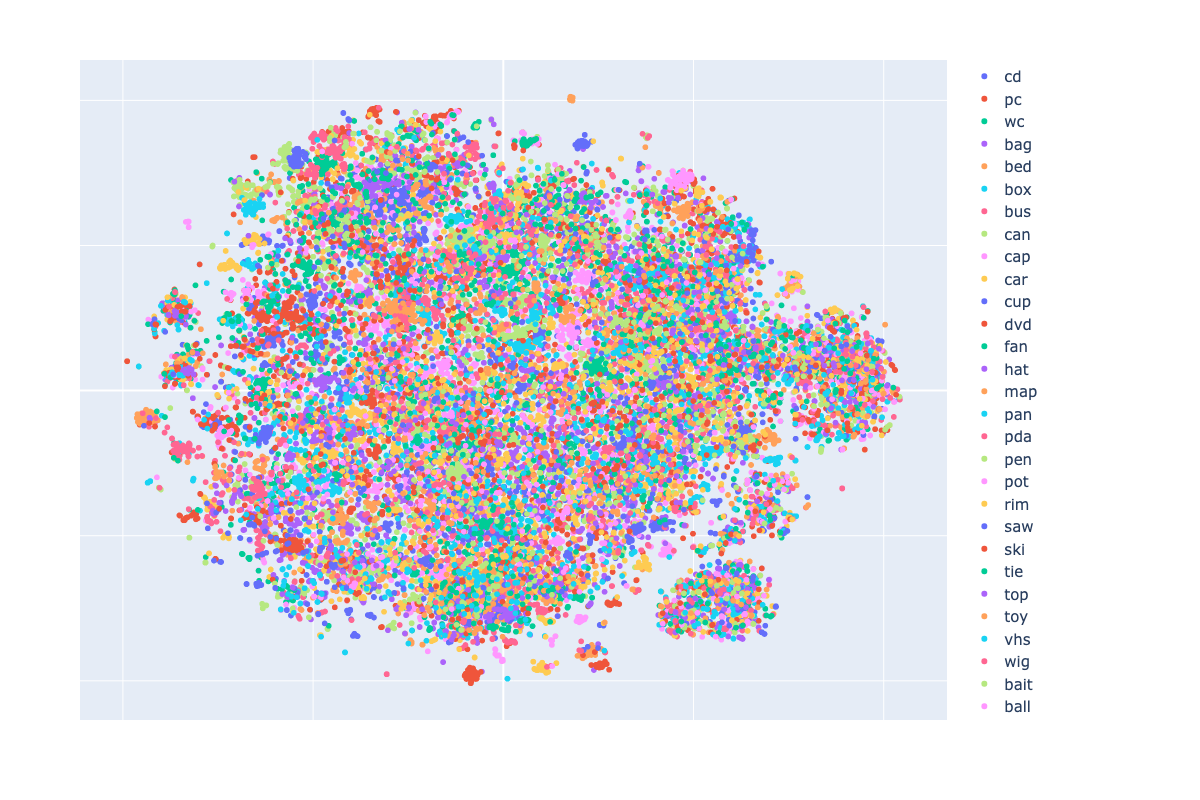

In [8]:
fig = px.scatter(df_plot, x=0,y=1,color='productType',hover_data=['title','subtitle'],width=1200,height=800)
fig.update_layout(font_size=15,legend=dict(title=""))
fig.update_yaxes(title='', showticklabels=False)
fig.update_xaxes(title='', showticklabels=False)
fig.show("png")

# Train linear model

In [9]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, f1_score

# Exclude only french since other languages are not correctly classified
df_de = df[ df['lang'] != 'fr' ].copy()

# Model input
X = vecs[df_de.index,:]
Y = df_de['productType']

#mod = LogisticRegression(class_weight='balanced',multi_class='multinomial',solver='lbfgs',max_iter=10,verbose=10)#,C=100)
mod = SGDClassifier(validation_fraction=0.2,early_stopping=True,verbose=0,max_iter=10,n_jobs=6,loss='log_loss') #due to time constraint, restrict to SGD

Y_pred = cross_val_predict(mod, X, Y, cv=30)
print('accuracy:', accuracy_score(Y,Y_pred).round(3))
print('f1:', f1_score(Y,Y_pred,average='weighted').round(3))

accuracy: 0.756
f1: 0.76


In [10]:
# Compare to without cross-validation
mod.fit(X,Y)
Y_pred_ = mod.predict(X)
print('accuracy:', accuracy_score(Y,Y_pred_).round(3))
print('f1:', f1_score(Y,Y_pred_,average='weighted').round(3))

accuracy: 0.916
f1: 0.917


# Confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y, Y_pred)
df_cm = pd.DataFrame(cm)

df_cm = pd.DataFrame(cm)
df_cm.index = mod.classes_
df_cm.columns = mod.classes_

diagonal_values = np.diag(df_cm)
indices = np.argsort(diagonal_values)

df_cm = df_cm.iloc[indices, :]
df_cm = df_cm[df_cm.index]

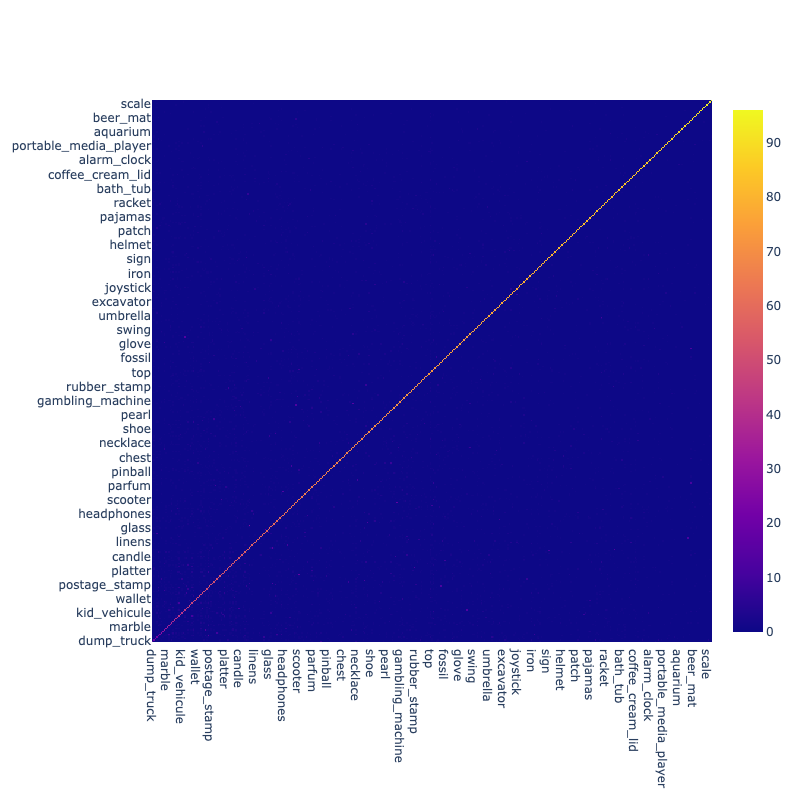

In [13]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=df_cm.values,
                   x=df_cm.columns,
                   y=df_cm.index,
                   hoverongaps = False))
fig.update_layout(autosize=False, width=800, height=800)
fig.show("png")

# Write model to app directory

In [30]:
import pickle
with open('../app/model.pkl', 'wb') as file:
    pickle.dump(mod, file)
